In [1]:
import pickle
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.5"

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from hyperion.utils import cherenkov_ang_dist, cherenkov_ang_dist_int, calc_tres
from torchinterp1d import Interp1d
from tqdm.notebook import tqdm, trange

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.set_default_dtype(torch.float64)

import sys

sys.path.append("../olympus")
from glob import glob
from itertools import product

import awkward as ak
import pandas as pd
from olympus.event_generation import (
    Detector,
    generate_cascade,
    make_hex_grid,
    make_line,
)
from hyperion.constants import Constants
from olympus.event_generation.mc_record import MCRecord
from olympus.event_generation.photon_propagation import (
    PhotonSource,
    dejit_sources,
    make_generate_bin_amplitudes_nn,
    make_generate_photons_nn,
    source_to_model_input,
)

from olympus.event_generation.lightyield import make_pointlike_cascade_source
from hyperion.models.photon_arrival_time.net import PhotonArivalTimePars
from hyperion.models.photon_arrival_time.pdf import make_exp_exp_exp, sample_exp_exp_exp
from hyperion.models.photon_binned_amplitude.net import make_net_eval_from_pickle
from hyperion.medium import cascadia_ref_index_func
from jax import jit
from jax import numpy as jnp
from jax import value_and_grad
from numba.typed import List
from torch.autograd.functional import hessian, jacobian

from fennel import Fennel, config

import json
%matplotlib inline
from scipy.integrate import quad

In [2]:
def make_triang(
    side_len,
    oms_per_line=20,
    dist_z=50,
    dark_noise_rate=16 * 1e-5,
    rng=np.random.RandomState(0),
):

    modules = make_line(
        -side_len/2, 0, oms_per_line, dist_z, rng, dark_noise_rate, 0, efficiency=0.3
    )
    modules += make_line(
        side_len/2, 0, oms_per_line, dist_z, rng, dark_noise_rate, 1, efficiency=0.3
    )
    modules += make_line(
        0,
        np.sqrt(3) / 2 * side_len,
        oms_per_line,
        dist_z,
        rng,
        dark_noise_rate,
        2,
        efficiency=0.3,
    )
    det = Detector(modules)

    return det

def sph_to_cart_np(theta, phi=0, r=1):
    """Transform spherical to cartesian coordinates."""
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    return np.asarray([x, y, z])

In [3]:
def c_medium_f(wl):
        """Speed of light in medium for wl (nm)."""
        return Constants.BaseConstants.c_vac / cascadia_ref_index_func(wl)

In [4]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50
dark_noise_rate = 16 * 1e-5  # 1/ns
det = make_triang(100, oms_per_line, dist_z, dark_noise_rate, rng)
module_positions = jnp.asarray(det.module_coords)
"""
gen_ph = make_generate_photons_nn(
    "../hyperion/data/arival_time_pars_net_w_arriv_pos.dat"
)
"""
model_func, binning = make_net_eval_from_pickle("data/arrival_hist_net_2tts_jax.pickle")

amp_gen_func = make_generate_bin_amplitudes_nn(model_func, binning, c_medium_f)


In [5]:
event_data = {"t0": 0., "theta": np.radians(30), "phi": np.radians(25), "pos": np.asarray([0, 0, 0.]), "energy": 5E5, "pid": 11}

event_dir = sph_to_cart_np(event_data["theta"], event_data["phi"])

In [6]:
"""
event, record = generate_cascade(
    det, event_data["pos"], event_data["t0"], event_dir, energy=event_data["energy"], particle_id=event_data["pid"], pprop_func=gen_ph,
    #converter_func=make_pointlike_cascade_source
)
"""

'\nevent, record = generate_cascade(\n    det, event_data["pos"], event_data["t0"], event_dir, energy=event_data["energy"], particle_id=event_data["pid"], pprop_func=gen_ph,\n    #converter_func=make_pointlike_cascade_source\n)\n'

In [7]:
149 * 60 

8940

In [8]:
event_binned, record = generate_cascade(
    det, event_data["pos"], event_data["t0"], event_dir, energy=event_data["energy"], particle_id=event_data["pid"], pprop_func=amp_gen_func,
#converter_func=make_pointlike_cascade_source
)

(8940, 2)


In [ ]:
"""
sources = [PhotonSource(np.asarray([0, 0, 0.]), 1E10, 0, np.asarray([0, 0, 1.])),
           PhotonSource(np.asarray([0, 0, 5.]), 1E10, 0, np.asarray([0, 0.5, 0.5]))]
event_binned = amp_gen_func(det.module_coords, det.module_efficiencies, sources)
event = gen_ph(det.module_coords, det.module_efficiencies, sources)
"""

'\nsources = [PhotonSource(np.asarray([0, 0, 0.]), 1E10, 0, np.asarray([0, 0, 1.])),\n           PhotonSource(np.asarray([0, 0, 5.]), 1E10, 0, np.asarray([0, 0.5, 0.5]))]\nevent_binned = amp_gen_func(det.module_coords, det.module_efficiencies, sources)\nevent = gen_ph(det.module_coords, det.module_efficiencies, sources)\n'

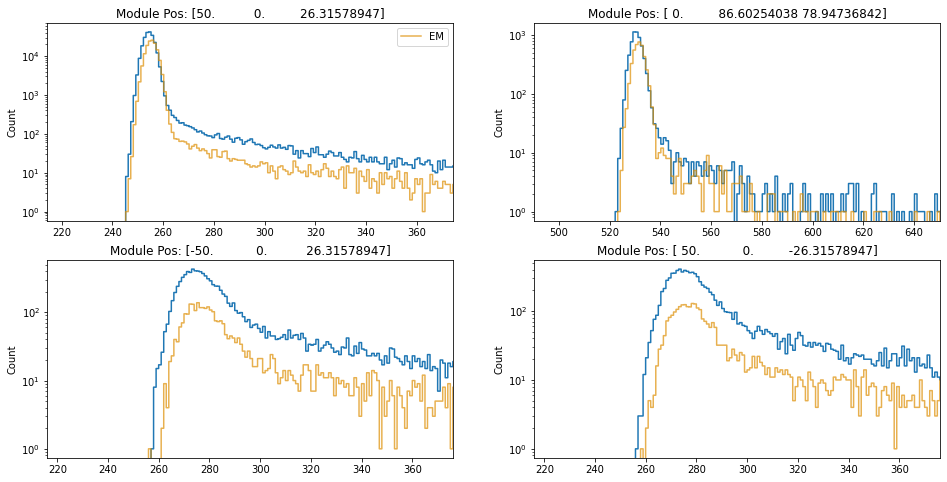

In [ ]:
c_medium = 0.299792458 / medium["n_ph"]
ixs = ak.argsort(ak.count(event, axis=1), ascending=False)
#binning = np.linspace(-20, 100, 120)

def add_tts(times, res):
    return times + np.random.normal(0, scale=res, size=len(times))


for res in [2]:
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))

    colors = sns.color_palette("colorblind")
    for ix, ax in zip(ixs, axs.ravel()):

        det_dist = np.linalg.norm(event_data["pos"] - det.module_coords[ix])

        times = np.asarray(event[ix])
        tgeo = event_data["t0"] + det_dist / c_medium
        
        amps, steps = event_binned[0][ix]
        amps = amps.detach().cpu()
        steps = steps.detach().cpu()

        #sns.histplot(add_tts(event3[ix], res)-tgeo, bins=binning, color=colors[0], ax=ax, alpha=0.7, element="step", fill=False, label="Pointlike")
        ax.step(steps, np.append(amps, amps[-1]), where="post")
        sns.histplot(add_tts(times, res), bins=steps, ax=ax, alpha=0.7, element="step", color=colors[1], fill=False, label="EM")
        
       
        
        #sns.histplot(add_tts(event2[ix], res)-tgeo, bins=binning, ax=ax, alpha=0.7, element="step", color=colors[2], fill=False, label="Hadr")

        ax.set_yscale("log")
        ax.set_title(f"Module Pos: { det.module_coords[ix]}")
        ax.set_xlim(steps[0] - 10, steps[0] + 150)
    axs[0][0].legend()

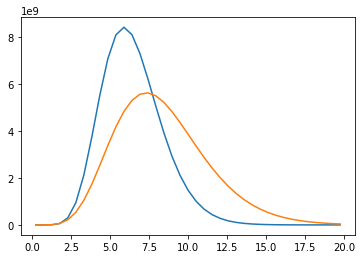

In [ ]:
test_energy = 5E5
em_counts_func, em_long_func, em_angles_func = fennel_instance.em_yields(energy=test_energy, particle=11, mean=True, function=True)
had_counts_func, had_long_func, had_em_func, had_angles_func = fennel_instance.hadron_yields(energy=test_energy, particle=211, mean=True, function=True)

zgrid = np.linspace(0, 15*100, 1000)

#em_counts_val = em_counts_func(test_energy, wavelengths, 11, mean=True)
em_long_val = em_long_func(test_energy, zgrid, fennel_instance._particles[11])
hadr_long_val = had_long_func(test_energy, zgrid, fennel_instance._particles[211])
#em_angles_val = em_angles_func(angle_grid, 1.33, fennel_instance._particles[11])





int_grid = np.linspace(0, 20, 40)
integrals_em = []
integrals_had = []
integrand_em = lambda z: em_long_func(event_data["energy"], z, particle=fennel_instance._particles[11])
integrand_had = lambda z: had_long_func(event_data["energy"], z, particle=fennel_instance._particles[211])

norm_em = scipy.integrate.quad(integrand_em, 0, np.infty)[0]
norm_had = scipy.integrate.quad(integrand_had, 0, np.infty)[0]
wavelengths = np.linspace(350, 500, 100)
nph_em = np.trapz(em_counts_func(test_energy, wavelengths, particle=11).ravel(), wavelengths)
nph_had = np.trapz(had_counts_func(test_energy, wavelengths, particle=211).ravel(), wavelengths)


event_dir = sph_to_cart_np(event_data["theta"], event_data["phi"])

ph_sources_em = []
ph_sources_had = []
for i in range(len(int_grid)-1):
    
    inte_em = scipy.integrate.quad(integrand_em, int_grid[i]*100, int_grid[i+1]*100)
    integrals_em.append(inte_em[0]/norm_em*nph_em)
    
    inte_had = scipy.integrate.quad(integrand_had, int_grid[i]*100, int_grid[i+1]*100)
    integrals_had.append(inte_had[0]/norm_had*nph_had)
    
    dist_along = 0.5*(int_grid[i] + int_grid[i+1])
    src_pos = dist_along * event_dir + event_data["pos"]
    ph_sources_em.append(
        PhotonSource(src_pos, inte_em[0]/norm_em*nph_em, event_data["t0"] + dist_along / 0.299792458, event_dir)
    )
    
    ph_sources_had.append(
        PhotonSource(src_pos, inte_had[0]/norm_had*nph_had, event_data["t0"] + dist_along / 0.299792458, event_dir)
    )

half = 0.5*(int_grid[1:] + int_grid[:-1])
    
plt.plot(half, integrals_em)
plt.plot(half, integrals_had)

In [ ]:
event = gen_ph(det.module_coords, det.module_efficiencies, ph_sources_em)
event2 = gen_ph(det.module_coords, det.module_efficiencies, ph_sources_had)

event3 = gen_ph(det.module_coords, det.module_efficiencies,
                [PhotonSource(event_data["pos"], nph, event_data["t0"], event_dir)])


/opt/conda/lib/python3.7/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sources' of function 'sample_times'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../gnn_testbed/gnn_testbed/event_generation/photon_propagation.py", line 236:
@jit(nopython=True)
def sample_times(pdf_params, sources, module_coords, module_efficiencies, time_geo):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [ ]:
det_dist

1.751211499790298e-08

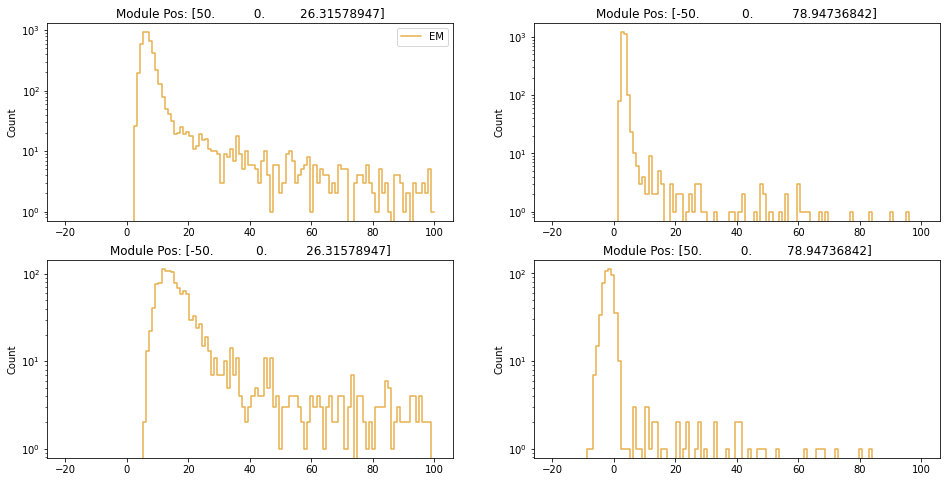

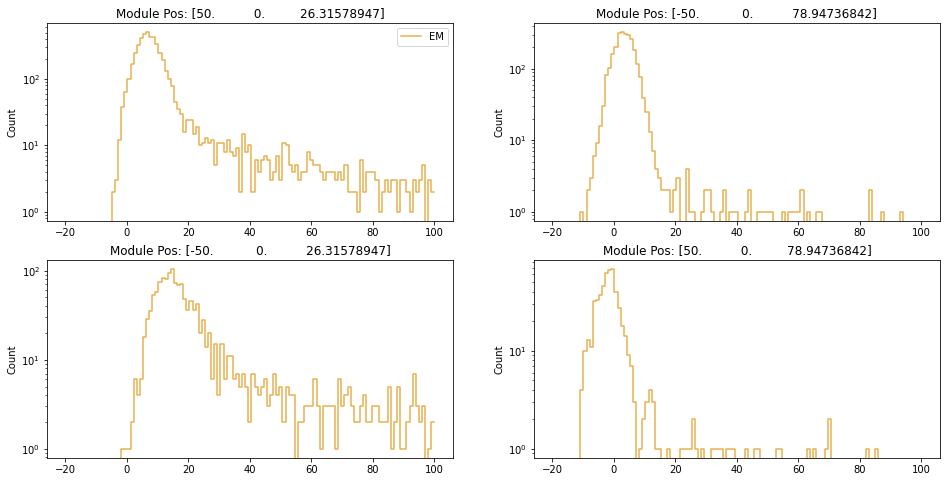

In [ ]:
c_medium = 0.299792458 / medium["n_ph"]
ixs = ak.argsort(ak.count(event, axis=1), ascending=False)
binning = np.linspace(-20, 100, 120)

def add_tts(times, res):
    return times + np.random.normal(0, scale=res, size=len(times))


for res in [0, 3,]:
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))

    colors = sns.color_palette("colorblind")
    for ix, ax in zip(ixs, axs.ravel()):

        det_dist = np.linalg.norm(event_data["pos"] - det.module_coords[ix])

        times = np.asarray(event[ix])
        tgeo = event_data["t0"] + det_dist / c_medium

        #sns.histplot(add_tts(event3[ix], res)-tgeo, bins=binning, color=colors[0], ax=ax, alpha=0.7, element="step", fill=False, label="Pointlike")
        sns.histplot(add_tts(times, res)-tgeo, bins=binning, ax=ax, alpha=0.7, element="step", color=colors[1], fill=False, label="EM")
        #sns.histplot(add_tts(event2[ix], res)-tgeo, bins=binning, ax=ax, alpha=0.7, element="step", color=colors[2], fill=False, label="Hadr")

        ax.set_yscale("log")
        ax.set_title(f"Module Pos: { det.module_coords[ix]}")
    axs[0][0].legend()

In [ ]:
event_data["dir"]

KeyError: 'dir'

1.1489956796984508

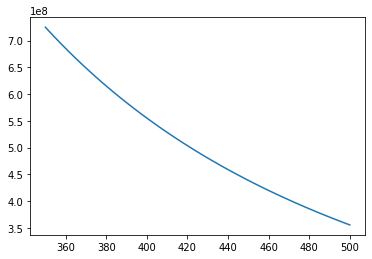

In [ ]:

plt.plot(wavelengths, em_counts_func(test_energy, wavelengths, particle=11))
 / (5.3 * 250 * 1E2 * test_energy  )

118410012272.75581

66250000000.0

In [ ]:
config['advanced']['wavelengths']

array([300., 310., 320., 330., 340., 350., 360., 370., 380., 390., 400.,
       410., 420., 430., 440., 450., 460., 470., 480., 490., 500., 510.,
       520., 530., 540., 550., 560., 570., 580., 590., 600.])

In [ ]:
em_counts_val / np.diff(wavelengths)[0]

NameError: name 'em_counts_val' is not defined

In [ ]:
event_data = {"t0":, 0, "theta": np.radians(10), "phi": np.radians(20), "pos": np.asarray([0, 0, 0.]), "energy": 1E5}
event, record = generate_cascade(
    det, pos, t0_gen, cdir, n_photons=amp_gen, pprop_func=gen_ph
)